In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import os

plt.rcParams['figure.dpi'] = 300

## 1. Loading in Met Data

In [5]:
# units: temp (degC), rainfall (mm)
met_data = pd.read_csv('C:/Users/jeanallen/Desktop/SHIFT_CWC/data/sedgwick_met_data.csv')
met_data = met_data.rename(columns={'Sedgwick Air Temp 10 m Avg degC' : 'temp10m',
                                    'Sedgwick Air Temp 2 m Avg degC' : 'temp2m',
                                    'Sedgwick Rainfall Cumulative mm' : 'cum_rainfall',
                                    'Sedgwick Rainfall mm' : 'rainfall',
                                    'Sedgwick Relative Humidity Avg %' : 'rel_humidity',
                                    })
met_data['datetime'] = pd.to_datetime(met_data['Time'])

In [6]:
# fill nan values in cum_rainfall with the previous value
met_data['cum_rainfall'] = met_data['cum_rainfall'].fillna(method='ffill')
met_data

,Time,temp10m,temp2m,cum_rainfall,rainfall,rel_humidity,datetime
0,2011-05-18 15:00:00,12.20,12.49,0.00,0.0,78.36,2011-05-18 15:00:00
1,2011-05-18 15:10:00,12.31,12.75,0.00,0.0,79.66,2011-05-18 15:10:00
2,2011-05-18 15:20:00,12.07,12.38,0.00,0.0,79.03,2011-05-18 15:20:00
3,2011-05-18 15:30:00,12.05,12.36,0.00,0.0,79.59,2011-05-18 15:30:00
4,2011-05-18 15:40:00,11.74,11.95,0.00,0.0,80.20,2011-05-18 15:40:00
...,...,...,...,...,...,...,...
695502,2024-08-07 12:00:00,32.62,33.73,542.29,0.0,28.54,2024-08-07 12:00:00
695503,2024-08-07 12:10:00,32.73,34.00,542.29,0.0,28.36,2024-08-07 12:10:00
695504,2024-08-07 12:20:00,33.07,34.25,542.29,0.0,28.03,2024-08-07 12:20:00
695505,2024-08-07 12:30:00,33.13,34.25,542.29,0.0,27.81,2024-08-07 12:30:00


## 2. Cumulative Rainfall Plot

In [7]:
# calculate water year and water year day
# runtime ~20 seconds
def water_year_day(date):
    water_year_date = datetime.strptime('2010-10-01', '%Y-%m-%d')
    water_year = date.year if date.month >= 10 else date.year - 1
    this_water_year_date = datetime.strptime(f'{water_year}-10-01', '%Y-%m-%d')
    return (date - this_water_year_date).days + 1

water_year_date = datetime.strptime('2010-10-01', '%Y-%m-%d')
met_data['water_year'] = met_data['datetime'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)
met_data['water_year'] = met_data['water_year'].astype(int)
met_data['water_year_day'] = met_data['datetime'].apply(lambda x: water_year_day(x))

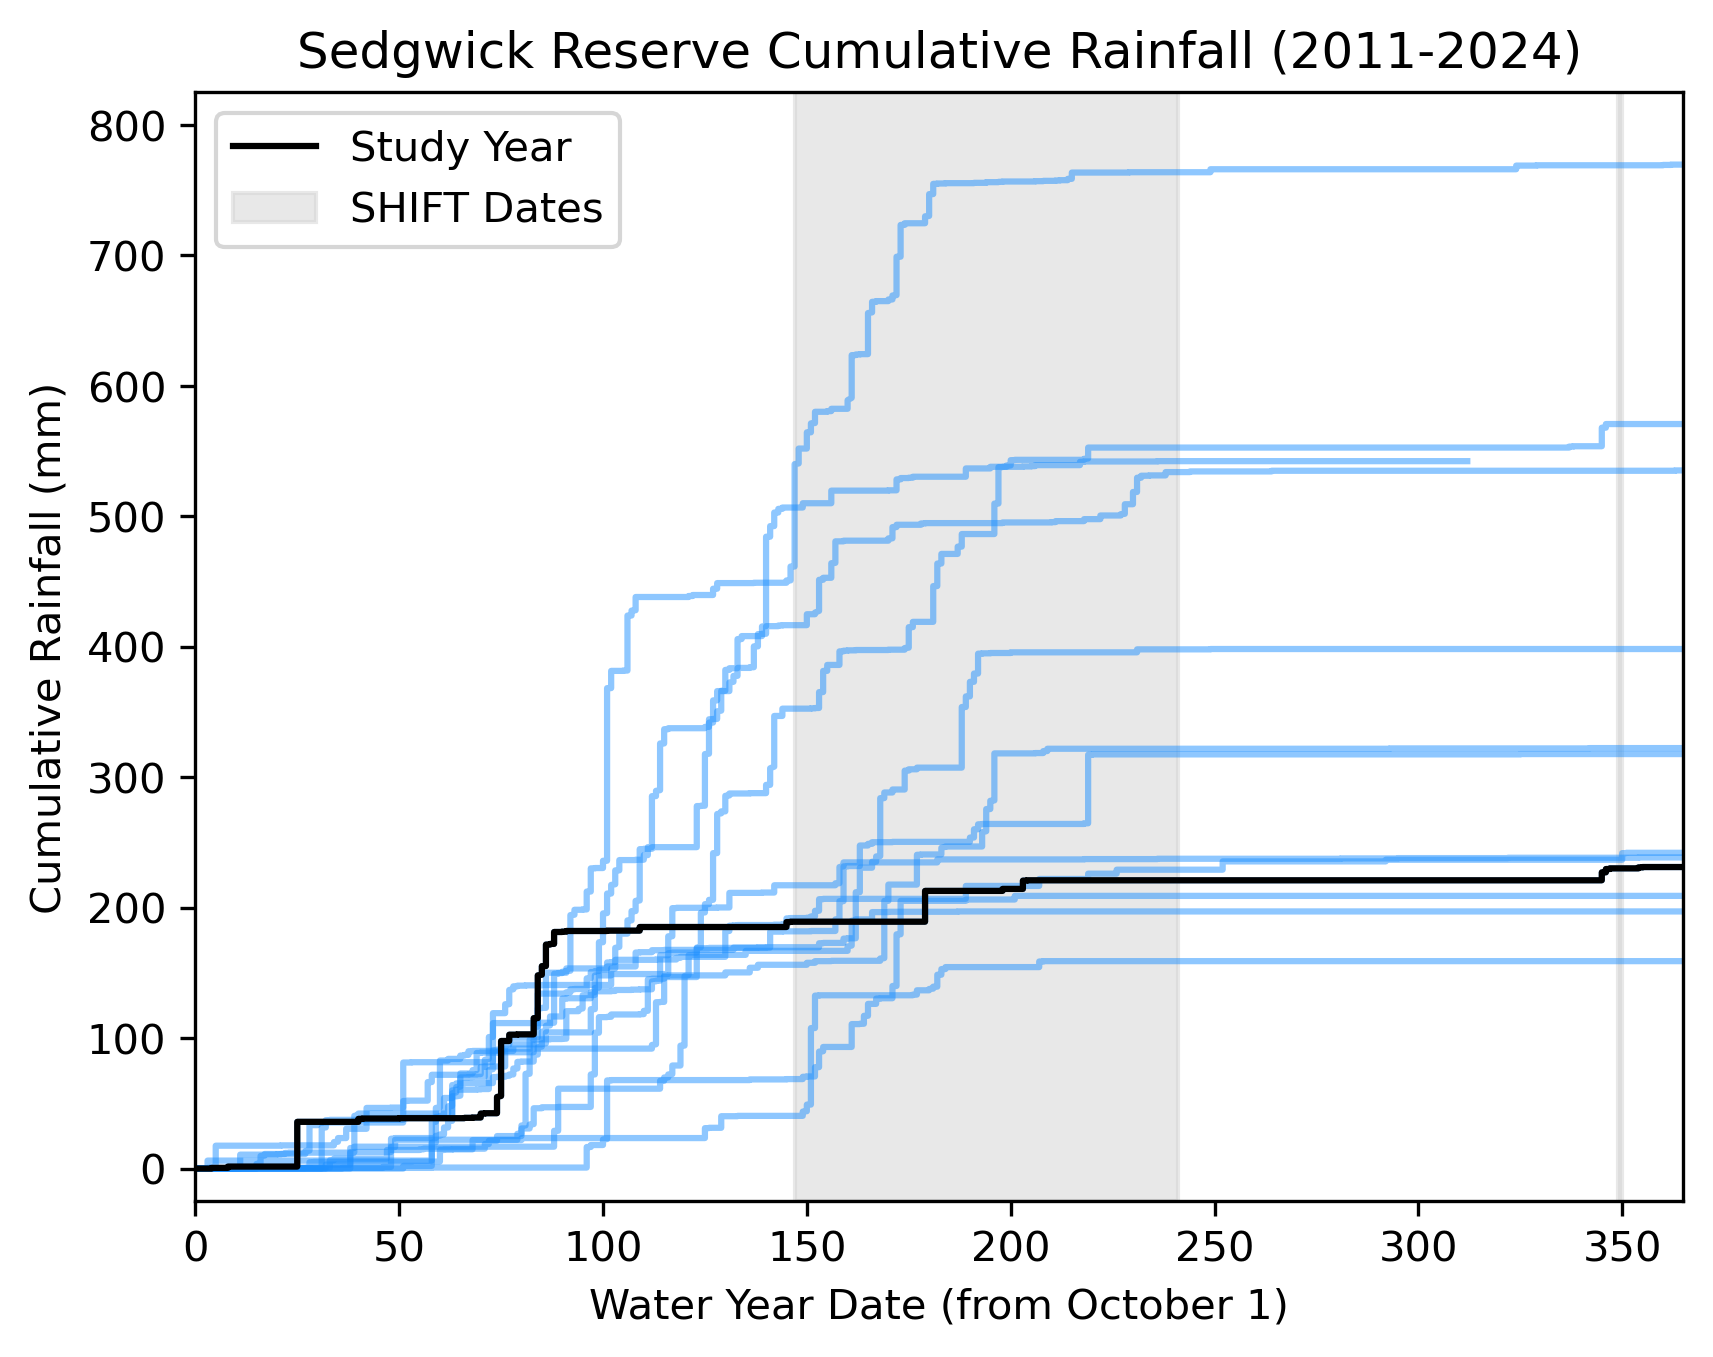

In [15]:
# plot cumulative rainfall for each year
for year in range(2011, 2024):
    plt.plot(met_data[met_data['water_year'] == year]['water_year_day'], met_data[met_data['water_year'] == year]['cum_rainfall'], color = 'dodgerblue', alpha=0.5)

# plot 2021 in black
plt.plot(met_data[met_data['water_year'] == 2021]['water_year_day'], met_data[met_data['water_year'] == 2021]['cum_rainfall'], label='Study Year', color = 'black')

# fill in between february 24 and may 29 for y values between 0 and 800
water_day_1 = water_year_day(datetime.strptime('2021-02-24', '%Y-%m-%d'))
water_day_2 = water_year_day(datetime.strptime('2021-05-29', '%Y-%m-%d'))
plt.fill_between([water_day_1, water_day_2], -25, 825, color='lightgrey', alpha=0.5, label='SHIFT Dates')
# same thing but for september 14 and september 15
water_day_1 = water_year_day(datetime.strptime('2021-09-14', '%Y-%m-%d'))
water_day_2 = water_year_day(datetime.strptime('2021-09-15', '%Y-%m-%d'))
plt.fill_between([water_day_1, water_day_2], -25, 825, color='lightgrey', alpha=0.5)



plt.xlabel('Water Year Date (from October 1)')
plt.ylabel('Cumulative Rainfall (mm)')
plt.title('Sedgwick Reserve Cumulative Rainfall (2011-2024)')
plt.xlim(0, 365)
plt.ylim(-25, 825)
plt.legend()

# plt.savefig('./precipitation.png')
plt.show()

In [9]:
cum_rainfalls = list(set(met_data[met_data['water_year_day'] == 365].cum_rainfall.values))
mean_cum_rainfall = np.mean(cum_rainfalls)
print(f'Mean cumulative rainfall per water year: {mean_cum_rainfall} mm')

Mean cumulative rainfall per water year: 322.9512307692308 mm


In [10]:
cum_rainfall_2021 = met_data[met_data['water_year'] == 2021]['rainfall'].sum()
print(f'Total rainfall in SHIFT water year: {cum_rainfall_2021} mm')

Total rainfall in SHIFT water year: 231.14 mm


## 3. Temperature Plot

In [19]:
# build new dataframe with daily averages
# runtime ~29 minutes if file doesn't exist
if os.path.exists('C:/Users/jeanallen/Desktop/SHIFT_CWC/data/sedgwick_daily_avg_temp.csv'):
    daily_avg_data = pd.read_csv('C:/Users/jeanallen/Desktop/SHIFT_CWC/data/sedgwick_daily_avg_temp.csv')
else:
    list_of_dates = [datetime.strptime(f'{year}-10-01', '%Y-%m-%d') + pd.Timedelta(days=i) for year in range(2011, 2024) for i in range(365)]
    avg_temps = []
    max_temps = []
    min_temps = []
    for date in list_of_dates:
        avg_temp = met_data[met_data['datetime'].dt.date == date.date()]['temp10m'].mean()
        avg_temps.append(avg_temp)
        max_temp = met_data[met_data['datetime'].dt.date == date.date()]['temp10m'].max()
        max_temps.append(max_temp)
        min_temp = met_data[met_data['datetime'].dt.date == date.date()]['temp10m'].min()
        min_temps.append(min_temp)
    daily_avg_data = pd.DataFrame({'date': list_of_dates, 'avg_temp': avg_temps}).dropna()
    daily_avg_data['water_year'] = daily_avg_data['date'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)
    daily_avg_data['water_year'] = daily_avg_data['water_year'].astype(int)
    daily_avg_data['water_year_day'] = daily_avg_data['date'].apply(lambda x: water_year_day(x))
    # save it out so we don't have to do this hullabaloo again
    daily_avg_data.to_csv('C:/Users/jeanallen/Desktop/SHIFT_CWC/data/sedgwick_daily_avg_temp.csv', index=False)


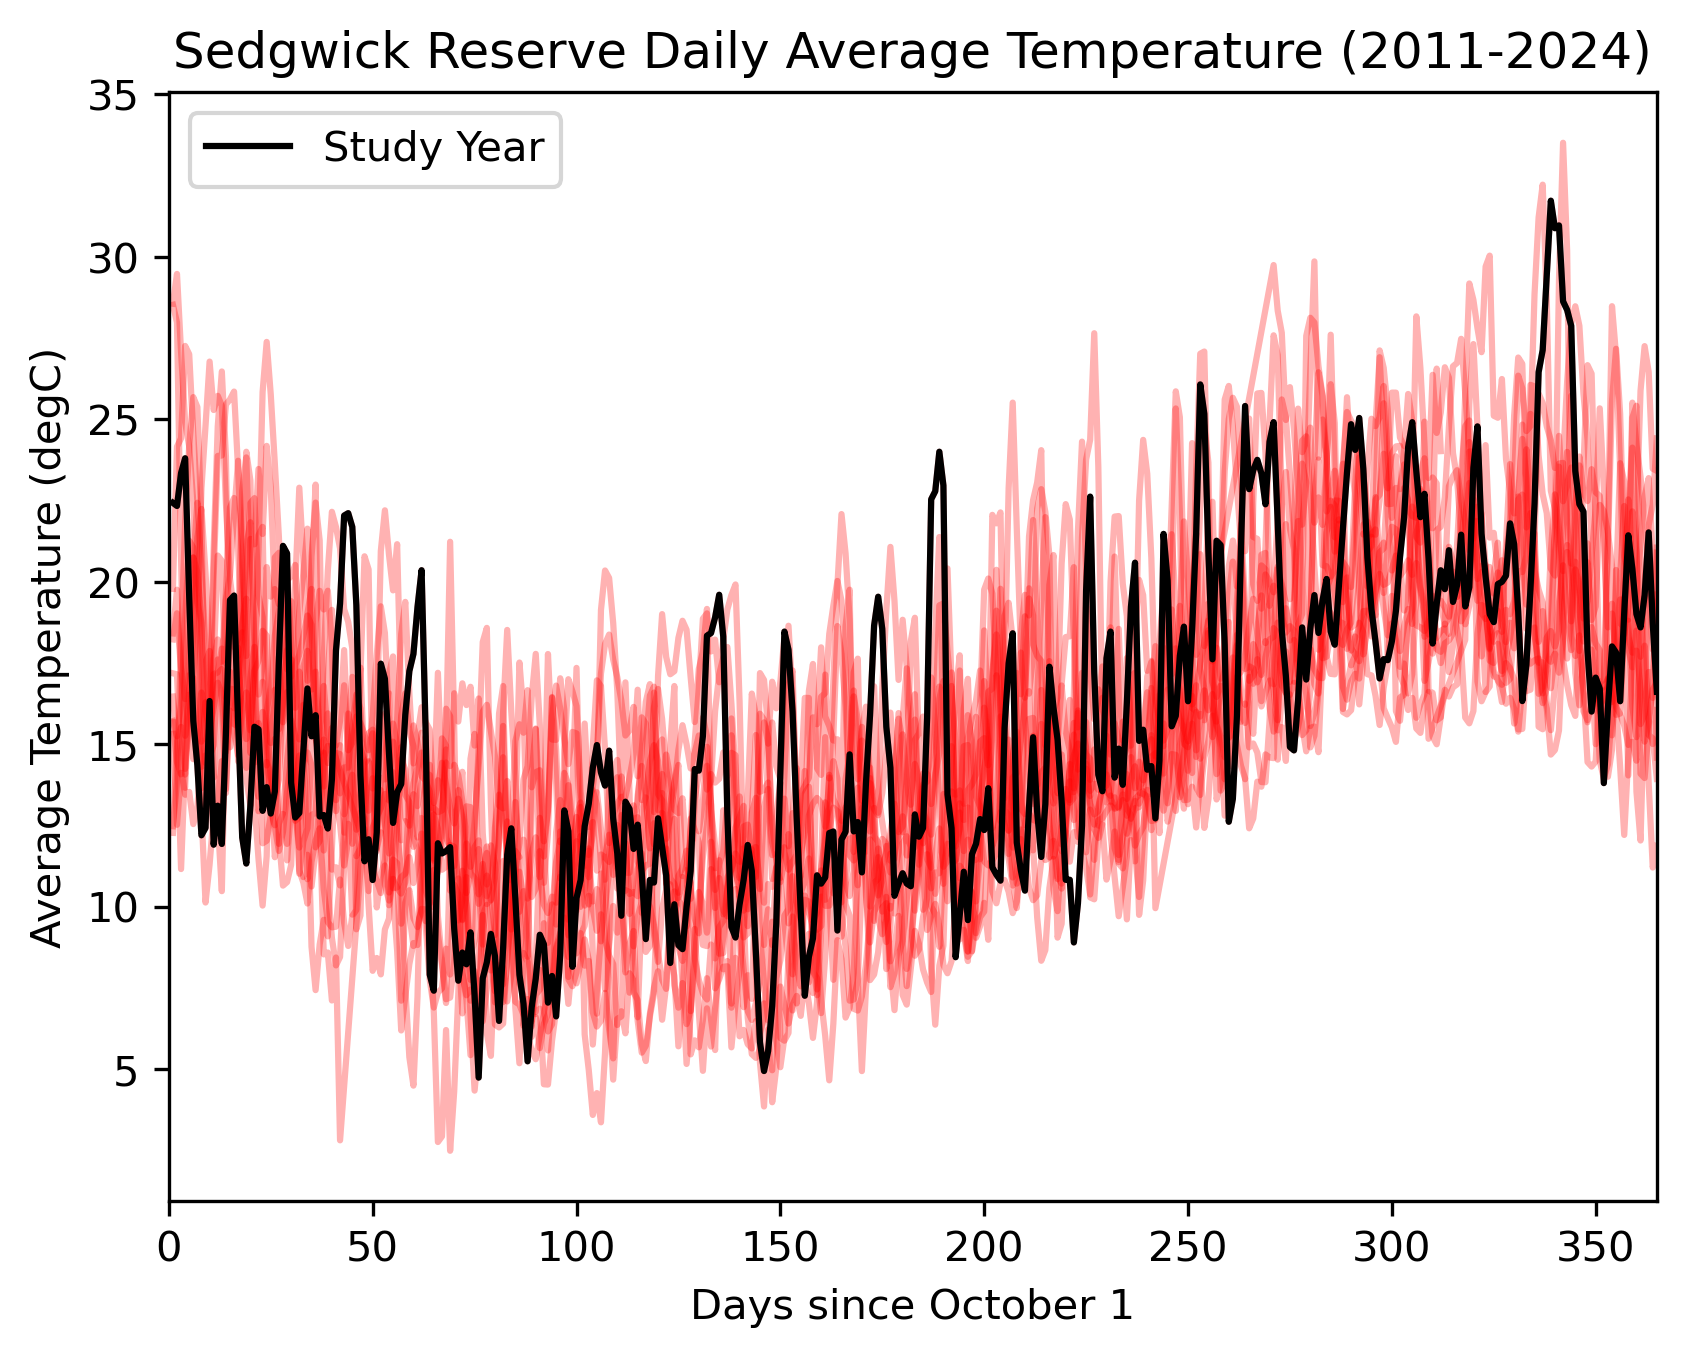

In [20]:
# plot daily average temperature for each year
for year in range(2011, 2024):
    plt.plot(daily_avg_data[daily_avg_data['water_year'] == year]['water_year_day'], daily_avg_data[daily_avg_data['water_year'] == year]['avg_temp'], color = 'red', alpha=0.3)

# plot 2021 in black
plt.plot(daily_avg_data[daily_avg_data['water_year'] == 2021]['water_year_day'], daily_avg_data[daily_avg_data['water_year'] == 2021]['avg_temp'], label='Study Year', color = 'black')

plt.xlabel('Days since October 1')
plt.ylabel('Average Temperature (degC)')
plt.title('Sedgwick Reserve Daily Average Temperature (2011-2024)')
plt.xlim(0, 365)
plt.legend()

plt.savefig('./temperature.png')